久保拓弥『データ解析のための統計モデリング入門』をJuliaでやってみます。

* 久保さんの書籍ページ：http://hosho.ees.hokudai.ac.jp/~kubo/ce/IwanamiBook.html
* Amazon.co.jp：https://amzn.to/2Cg5vDJ

# 第6章 GLMの応用範囲を広げる ---ロジスティック回帰など---

ポアソン分布・対数リンク関数の組み合わせ以外も使ってみよう、の章。

## 6.1 さまざまな種類のデータで応用できるGLM（p.114）

表6.1に近いものが http://juliastats.github.io/GLM.jl/stable/manual/#Fitting-GLM-models-1 に載っている。

| 確率分布     | family指定           | 正準リンク関数 |
| ------------ | -------------------- | -----------------|
| [二項分布](https://ja.wikipedia.org/w/index.php?title=%E4%BA%8C%E9%A0%85%E5%88%86%E5%B8%83)     | `Binomial()`         | `LogitLink()`    |
| [ポアソン分布](https://ja.wikipedia.org/wiki/%E3%83%9D%E3%82%A2%E3%82%BD%E3%83%B3%E5%88%86%E5%B8%83) | `Poisson()`          | `LogLink()`      |
| [負の二項分布](https://ja.wikipedia.org/wiki/%E8%B2%A0%E3%81%AE%E4%BA%8C%E9%A0%85%E5%88%86%E5%B8%83) | `NegativeBinomial()` | `LogLink()`      |
| [ガンマ分布](https://ja.wikipedia.org/wiki/%E3%82%AC%E3%83%B3%E3%83%9E%E5%88%86%E5%B8%83)   | `Gamma ()`           | `InverseLink()`  |
| [正規分布](https://ja.wikipedia.org/wiki/%E6%AD%A3%E8%A6%8F%E5%88%86%E5%B8%83)     | `Normal()`           | `IdentityLink()` |

Distributions.jlが入れてあれば、

* 確率密度関数は`pdf(Normal(mu, sigma), x)`
* 累積分布関数は`cdf(Normal(mu, sigma), x)`
* 乱数生成は`rand(Normal(mu, sigma), n)`

のように使える。

In [1]:
using DataFrames
using CSV
using Distributions
using GLM
using Plots
pyplot()
using StatsPlots
versioninfo()

Julia Version 1.1.0
Commit 80516ca202 (2019-01-21 21:24 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin14.5.0)
  CPU: Intel(R) Core(TM) i7-7920HQ CPU @ 3.10GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-6.0.1 (ORCJIT, skylake)


## 6.2 例題：上限のあるカウントデータ（p.115）

In [2]:
d = CSV.read("data4a.csv")
describe(d)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Union…,Int64,DataType
1,N,8.0,8,8.0,8,,0,Int64
2,y,5.08,0,6.0,8,,0,Int64
3,x,9.9672,7.66,9.965,12.44,,0,Float64
4,f,,C,,T,2,0,String


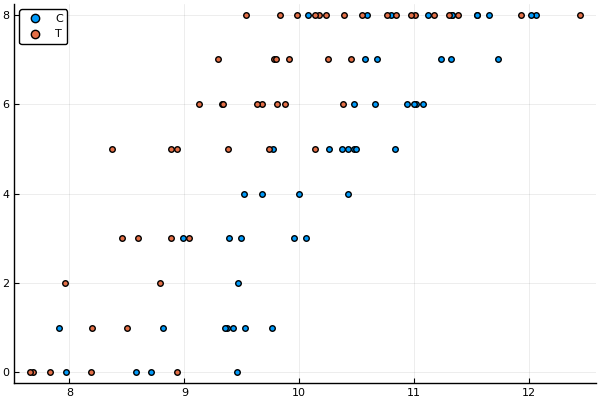

In [3]:
@df d scatter(:x, :y, group=:f)

## 6.3 二項分布で表現する「あり・なし」カウントデータ（p.118）

$$ p\left(y | N, q\right) = \binom{N}{y} q^y \left(1-q\right)^{N-y} $$

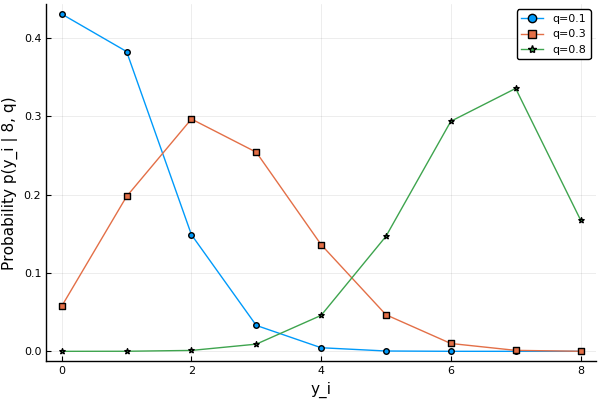

In [4]:
y = 0:8
plot(y, pdf.(Binomial(8, 0.1), y), marker=:auto, label="q=0.1", xlabel="y_i", ylabel="Probability p(y_i | 8, q)")
plot!(y, pdf.(Binomial(8, 0.3), y), marker=:auto, label="q=0.3")
plot!(y, pdf.(Binomial(8, 0.8), y), marker=:auto, label="q=0.8")

## 6.4 ロジスティック回帰とロジットリンク関数

### 6.4.1 ロジットリンク関数（p.119）

**ロジスティック関数**（_logistic function_）
$$ q_i = \mathrm{logistic}\left(z_i\right) = \frac{1}{1 + \exp\left(-z_i\right)} $$
$$ z_i = \beta_1 + \beta_2 x_i + \cdots $$

線形予測子の部分の定義が、本とDistribution.jlの`Logistic()`とで違うっぽいのでどうしようかなぁ、というところ。下のものが[Wikipedia](http://en.wikipedia.org/wiki/Logistic_distribution)に載っていた式。

$$f\left(x; \mu, \theta\right) = \frac{1}{1 + \exp\left(-\frac{x-\mu}{\theta}\right)}$$

$\exp$の中は$-z_i = -\frac{x-\mu}{\theta}$つまり$\beta_1 + \beta_2 x_i = \frac{1}{\theta}x_i - \frac{\mu}{\theta}$なので、$\beta_1 = -\frac{\mu}{\theta}$, $\beta_2 = \frac{1}{\theta}$でいいのかな。つまり$\mu = -\beta_1\theta$, $\theta = \frac{1}{\beta_2}$？

In [5]:
?Logistic

search: Logistic logistic



```
Logistic(μ,θ)
```

The *Logistic distribution* with location `μ` and scale `θ` has probability density function

$$
f(x; \mu, \theta) = \frac{1}{4 \theta} \mathrm{sech}^2
\left( \frac{x - \mu}{2 \theta} \right)
$$

```julia
Logistic()       # Logistic distribution with zero location and unit scale, i.e. Logistic(0, 1)
Logistic(u)      # Logistic distribution with location u and unit scale, i.e. Logistic(u, 1)
Logistic(u, b)   # Logistic distribution with location u ans scale b

params(d)       # Get the parameters, i.e. (u, b)
location(d)     # Get the location parameter, i.e. u
scale(d)        # Get the scale parameter, i.e. b
```

External links

  * [Logistic distribution on Wikipedia](http://en.wikipedia.org/wiki/Logistic_distribution)


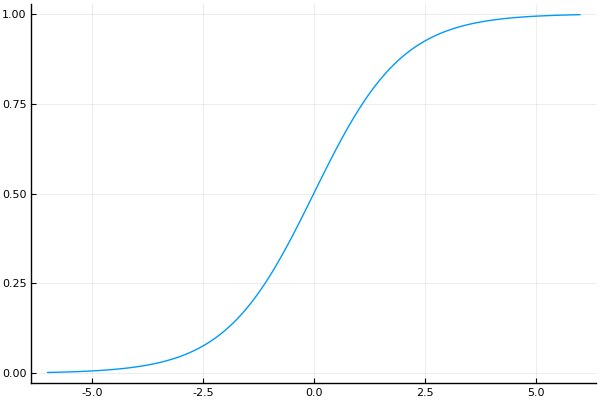

In [6]:
z = range(-6, stop=6, step=0.1)
b1 = 0; b2 = 1;
theta = 1 / b2
mu = -b1 * theta
plot(z, cdf.(Logistic(mu, theta), z), legend=false)

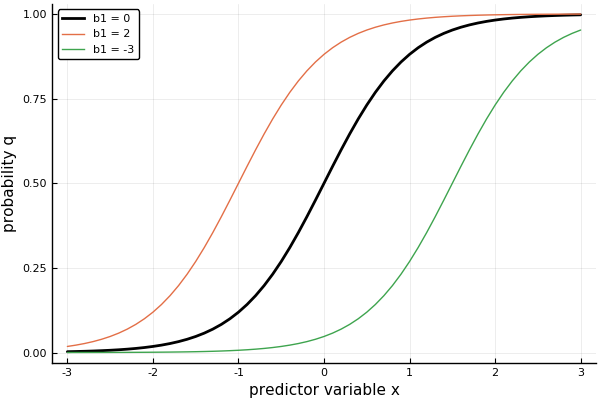

In [7]:
z = range(-3, stop=3, step=0.1)

b1 = 0; b2 = 2;
theta = 1 / b2
mu = -b1 * theta
plot(z, cdf.(Logistic(mu, theta), z), color=:black, linewidth=2, xlabel="predictor variable x", ylabel="probability q", label="b1 = 0")

b1 = 2; b2 = 2;
theta = 1 / b2
mu = -b1 * theta
plot!(z, cdf.(Logistic(mu, theta), z), label="b1 = 2")

b1 = -3; b2 = 2;
theta = 1 / b2
mu = -b1 * theta
plot!(z, cdf.(Logistic(mu, theta), z), label="b1 = -3")

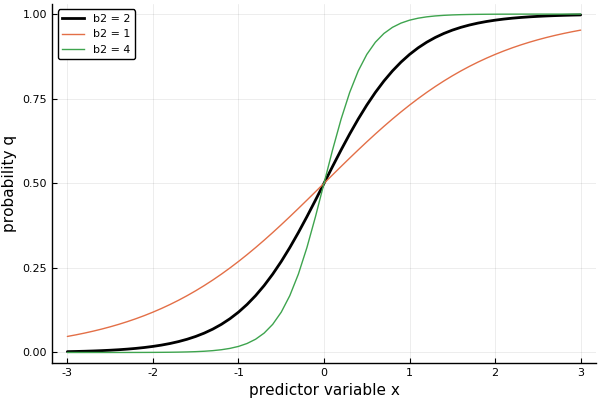

In [8]:
z = range(-3, stop=3, step=0.1)

b1 = 0; b2 = 2;
theta = 1 / b2
mu = -b1 * theta
plot(z, cdf.(Logistic(mu, theta), z), color=:black,
    xlabel="predictor variable x", ylabel="probability q", label="b2 = 2", linewidth=2)

b1 = 0; b2 = 1;   # 負値が扱えないので正にしておいた
theta = 1 / b2
mu = -b1 * theta
plot!(z, cdf.(Logistic(mu, theta), z), label="b2 = 1")

b1 = 0; b2 = 4;
theta = 1 / b2
mu = -b1 * theta
plot!(z, cdf.(Logistic(mu, theta), z), label="b2 = 4")

$\theta$を負値にすることができないけれど、βの値によって動くのは確認できた。p.121のグラフとも合致するのでOKぽい。

**ロジット関数**（_logit function_）はロジスティック関数の逆関数
$$ \log\frac{q_i}{1 - q_i} = z_i $$
$$ \mathrm{logit}\left(q_i\right) = \log\frac{q_i}{1 - q_i} $$

### 6.4.2 パラメータ推定（p.122）

尤度関数：
$$ L\left(\left\{\beta_j\right\}\right) = \prod_i \binom{N_i}{y_i} q^{y_i} \left(1-q\right)^{N_i-y_i} $$

対数尤度関数：
$$ \log L\left(\left\{\beta_j\right\}\right) = \sum_i\left\{\log\binom{N_i}{y_i} + y_i\log\left(q_i\right) + \left(N_i-y_i\right) \log\left(1-q\right) \right\}$$

Rのglmだと応答変数として成功・失敗の二つの値を渡すために`cbind(y, N-y)`とやっているけど、GLM.jlだと成功比率っぽいので`y_ratio`を計算して使っている。

In [9]:
d[:y_ratio] = d[:y] ./ d[:N]
fit_xf = glm(@formula(y_ratio ~ x + f), d, Binomial(), LogitLink())

StatsModels.DataFrameRegressionModel{GeneralizedLinearModel{GlmResp{Array{Float64,1},Binomial{Float64},LogitLink},DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: y_ratio ~ 1 + x + f

Coefficients:
             Estimate Std.Error  z value Pr(>|z|)
(Intercept)  -19.5361   3.99861 -4.88572    <1e-5
x             1.95241  0.392777  4.97077    <1e-6
f: T          2.02151  0.654152  3.09027   0.0020


[Stack Overflowにも同様の質問](https://stackoverflow.com/questions/33874667/binomial-glm-in-julia-how-to-specify-hits-and-misses)があって、そこでは以下のようなかんじでやるのだと書かれていたが、これでいいのか？（`glm`の出力もよくわからないし、対数尤度の値なども教科書と違う）

In [10]:
# spreading dataset to one row per trial...
xv = [];
for n=1:length(d[:y])
    xv = vcat(xv, repeat([d[:x][n]], d[:y][n]))
end
for n=1:length(d[:y])
    xv = vcat(xv, repeat([d[:x][n]], d[:N][n]-d[:y][n]))
end
data = DataFrame(
    xvals = xv,
    outcome = vcat(repeat([1], sum(d[:y])), repeat([0], sum(d[:N]-d[:y])))
)

,xvals,outcome
,Any,Int64
1,9.76,1
2,10.48,1
3,10.48,1
4,10.48,1
5,10.48,1
6,10.48,1
7,10.48,1
8,10.83,1
9,10.83,1


In [11]:
fit1 = glm(@formula(outcome ~ xvals), data, Binomial(), LogitLink())

StatsModels.DataFrameRegressionModel{GeneralizedLinearModel{GlmResp{Array{Float64,1},Binomial{Float64},LogitLink},DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: outcome ~ 1 + xvals

Coefficients:
                Estimate Std.Error     z value Pr(>|z|)
(Intercept)     -14.5661   312.097  -0.0466716   0.9628
xvals: 7.68   2.87937e-9   441.372 6.52367e-12   1.0000
xvals: 7.83   2.87937e-9   441.372 6.52368e-12   1.0000
xvals: 7.91      12.6202   312.099   0.0404364   0.9677
xvals: 7.96      13.4675   312.098   0.0431514   0.9656
xvals: 7.97   2.87937e-9   441.372 6.52367e-12   1.0000
xvals: 8.19   2.87937e-9   441.372 6.52368e-12   1.0000
xvals: 8.2       12.6202   312.099   0.0404364   0.9677
xvals: 8.37      15.0769   312.098   0.0483082   0.9615
xvals: 8.46      14.0552   312.098   0.0450347   0.9641
xvals: 8.5       12.6202   312.099   0.0404364   0.9677
xvals: 8.58   2.87937e-9   441.372 6.52368e-12   1.0000
xvals: 8.6       14.05

In [12]:
loglikelihood(fit1)

-283.77042376190326

In [13]:
deviance(fit1)

567.5408475238057

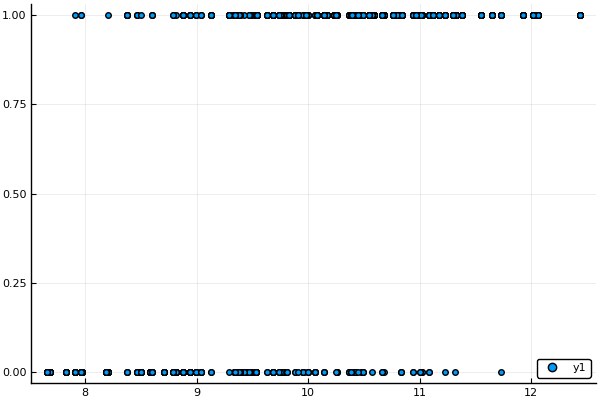

In [14]:
@df data scatter(:xvals, :outcome)

さておき、ちょっといいかげんだけど図6.7に相当するグラフも作ってみた。

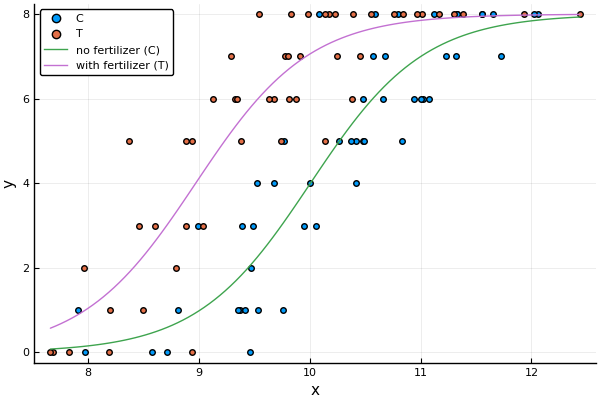

In [15]:
z = range(minimum(d[:x]), stop=maximum(d[:x]), length=101)
b1 = -19.5361; b2 = 1.95241; b3=2.02151;

theta = 1 / b2
mu = -b1 * theta
@df d scatter(:x, :y, group=:f, xlabel="x", ylabel="y", legend=:topleft)
plot!(z, cdf.(Logistic(mu, theta), z) * 8, label="no fertilizer (C)")

theta = 1 / b2
mu = -(b1 + b3) * theta
plot!(z, cdf.(Logistic(mu, theta), z) * 8, label="with fertilizer (T)")

### 6.4.4 ロジスティック回帰のモデル選択（p.126）

なぜか下記コードで`loglikelihood(fit_x)`などが出来ないので、残差逸脱度からでAIC的なものを考えてみる。残差逸脱度はフルモデルとの距離なので、AICの代わりに$\mathrm{残差逸脱度} + 2k$を使っても実質的に同じはず。（ただ、p.127の表6.2と違う残差逸脱度の値が出てくるので、よく分からん……）

In [16]:
d[:y_ratio] = d[:y] ./ d[:N]

fit_1 = glm(@formula(y_ratio ~ 1), d, Binomial(), LogitLink())
fit_f = glm(@formula(y_ratio ~ f), d, Binomial(), LogitLink())
fit_x = glm(@formula(y_ratio ~ x), d, Binomial(), LogitLink())
fit_xf = glm(@formula(y_ratio ~ x + f), d, Binomial(), LogitLink())

println(deviance(fit_1) + 2*dof(fit_1))
println(deviance(fit_f) + 2*dof(fit_f))
println(deviance(fit_x) + 2*dof(fit_x))
println(deviance(fit_xf) + 2*dof(fit_xf))

64.40401283480597
65.32281430909224
31.146025537473253
21.379236287661676


Rでやってみると以下のようになった（RCall.jl便利だなー）。当たり前だが、こっちは教科書どおり。

In [17]:
using RCall
R"""
d <- read.csv("data4a.csv")
fit.xf <- glm(cbind(y, N-y) ~ x + f, data=d, family=binomial)
library(MASS)
stepAIC(fit.xf)
"""

Start:  AIC=272.21
cbind(y, N - y) ~ x + f

       Df Deviance    AIC
<none>      123.03 272.21
- f     1   217.17 364.35
- x     1   490.58 637.76


RObject{VecSxp}

Call:  glm(formula = cbind(y, N - y) ~ x + f, family = binomial, data = d)

Coefficients:
(Intercept)            x           fT  
    -19.536        1.952        2.022  

Degrees of Freedom: 99 Total (i.e. Null);  97 Residual
Null Deviance:	    499.2 
Residual Deviance: 123 	AIC: 272.2


## 6.5 交互作用項の入った線形予測子

In [18]:
fit_all = glm(@formula(y_ratio ~ x * f), d, Binomial(8), LogitLink())

StatsModels.DataFrameRegressionModel{GeneralizedLinearModel{GlmResp{Array{Float64,1},Binomial{Float64},LogitLink},DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: y_ratio ~ 1 + x + f + x & f

Coefficients:
               Estimate Std.Error     z value Pr(>|z|)
(Intercept)    -18.5233    5.3347    -3.47223   0.0005
x               1.85251  0.524881     3.52939   0.0004
f: T         -0.0637634   7.64612 -0.00833931   0.9933
x & f: T       0.216337  0.792117    0.273113   0.7848


In [19]:
println(deviance(fit_all) + 2*dof(fit_all))

23.30416971775555


今回のケースでは交互作用を入れると（上記のAIC的な何かの）値が上昇するのが分かる。

## 6.6 割算値の統計モデリングはやめよう

...と言われましても、GLM.jlの`Binomial()`では応答変数には0〜1の値しか受け付けてくれないようなので、いまのやり方では難しそう。`offset`も[GML.jlでの使われ方](http://juliastats.github.io/GLM.jl/stable/api/#StatsBase.predict)は少し違うかも。

## 6.7 正規分布とその尤度

正規分布の**確率密度関数**
$$ p\left(y | \mu,\sigma\right) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left\{-\frac{\left(y-\mu\right)^2}{2\sigma^2}\right\} $$

In [20]:
?Normal

search: Normal NormalCanon NormalInverseGaussian MvNormal MvNormalCanon



```
Normal(μ,σ)
```

The *Normal distribution* with mean `μ` and standard deviation `σ` has probability density function

$$
f(x; \mu, \sigma) = \frac{1}{\sqrt{2 \pi \sigma^2}}
\exp \left( - \frac{(x - \mu)^2}{2 \sigma^2} \right)
$$

```julia
Normal()          # standard Normal distribution with zero mean and unit variance
Normal(mu)        # Normal distribution with mean mu and unit variance
Normal(mu, sig)   # Normal distribution with mean mu and variance sig^2

params(d)         # Get the parameters, i.e. (mu, sig)
mean(d)           # Get the mean, i.e. mu
std(d)            # Get the standard deviation, i.e. sig
```

External links

  * [Normal distribution on Wikipedia](http://en.wikipedia.org/wiki/Normal_distribution)


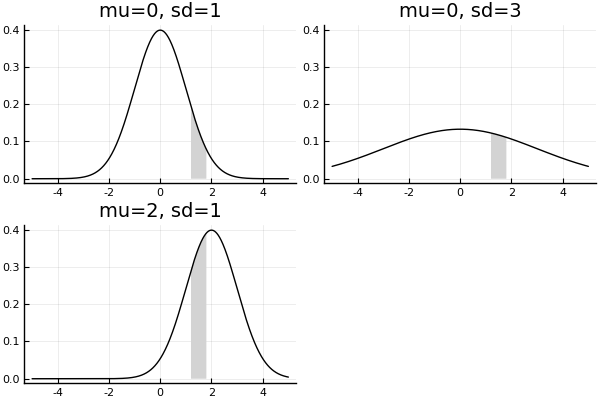

In [21]:
y = range(-5, stop=5, step=0.01)
y1 = range(1.2, stop=1.8, step=0.01)
plot(y1, pdf.(Normal(0, 1), y1), legend=false, layout=3, fill=true, line=false, fillcolor=:lightgrey, subplot=1)
plot!(y, pdf.(Normal(0, 1), y), subplot=1, linecolor=:black, title="mu=0, sd=1", ylim=[0, 0.4])

plot!(y1, pdf.(Normal(0, 3), y1), legend=false, fill=true, line=false, fillcolor=:lightgrey, subplot=2)
plot!(y, pdf.(Normal(0, 3), y), linecolor=:black, subplot=2, title="mu=0, sd=3", ylim=[0, 0.4])

plot!(y1, pdf.(Normal(2, 1), y1), legend=false, fill=true, line=false, fillcolor=:lightgrey, subplot=3)
plot!(y, pdf.(Normal(2, 1), y), linecolor=:black, subplot=3, title="mu=2, sd=1", ylim=[0, 0.4])

In [22]:
cdf(Normal(0, 1), 1.8) - cdf(Normal(0, 1), 1.2)

0.07913935110878245

In [23]:
# 長方形として粗く近似
pdf(Normal(0, 1), (1.8+1.2)/2) * (1.8 - 1.2)

0.07771055739953506

正規分布の最尤推定。

$$ L\left(\mu, \sigma\right) = \prod_i p\left(y_i | \mu,\sigma\right) \Delta y = \prod_i \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left\{-\frac{\left(y_i - \mu\right)^2}{2\sigma^2}\right\}  \Delta y $$
$$ \log L\left(\mu, \sigma\right) = -\frac{1}{2}N\log\left(2\pi\sigma^2\right) - \frac{1}{2\sigma^2}\sum_i\left(y_i - \mu\right)^2 + N\log\left(\Delta y\right) $$

## 6.8 ガンマ分布のGLM

$$ p\left(y | s, r\right) = \frac{r^s}{\Gamma\left(s\right)}y^{s-1}\exp\left(-ry\right) $$

sはshapeパラメータ、rはrateパラメータ。平均は$s/r$、分散は$s/r^2$。Distribution.jlのGamma関数は$\alpha=s$と$\theta=1/r$（脚注42によるとscaleパラメータ）という引数を取る。

In [24]:
?Gamma

search: Gamma gamutmax InverseGamma gamutmin



```
Gamma(α,θ)
```

The *Gamma distribution* with shape parameter `α` and scale `θ` has probability density function

$$
f(x; \alpha, \theta) = \frac{x^{\alpha-1} e^{-x/\theta}}{\Gamma(\alpha) \theta^\alpha},
\quad x > 0
$$

```julia
Gamma()          # Gamma distribution with unit shape and unit scale, i.e. Gamma(1, 1)
Gamma(α)         # Gamma distribution with shape α and unit scale, i.e. Gamma(α, 1)
Gamma(α, θ)      # Gamma distribution with shape α and scale θ

params(d)        # Get the parameters, i.e. (α, θ)
shape(d)         # Get the shape parameter, i.e. α
scale(d)         # Get the scale parameter, i.e. θ
```

External links

  * [Gamma distribution on Wikipedia](http://en.wikipedia.org/wiki/Gamma_distribution)


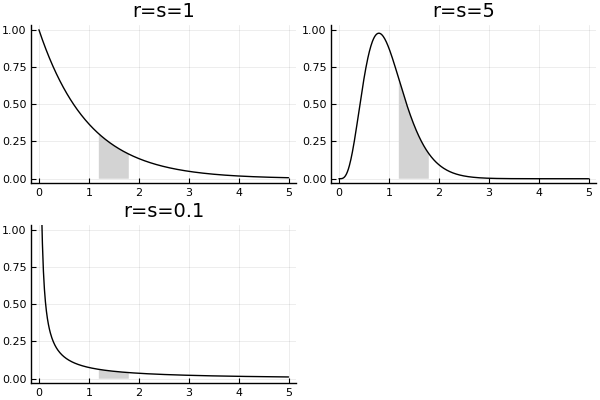

In [25]:
y = range(0, stop=5, step=0.01)
y1 = range(1.2, stop=1.8, step=0.01)

plot(y1, pdf.(Gamma(1, 1), y1), legend=false, layout=3, fill=true, line=false, fillcolor=:lightgrey, subplot=1)
plot!(y, pdf.(Gamma(1, 1), y), subplot=1, linecolor=:black, title="r=s=1", ylim=[0, 1])

plot!(y1, pdf.(Gamma(5, 1/5), y1), legend=false, fill=true, line=false, fillcolor=:lightgrey, subplot=2)
plot!(y, pdf.(Gamma(5, 1/5), y), linecolor=:black, subplot=2, title="r=s=5", ylim=[0, 1])

plot!(y1, pdf.(Gamma(0.1, 1/0.1), y1), legend=false, fill=true, line=false, fillcolor=:lightgrey, subplot=3)
plot!(y, pdf.(Gamma(0.1, 1/0.1), y), linecolor=:black, subplot=3, title="r=s=0.1", ylim=[0, 1])

久保さんのウェブサイトからダウンロードできる`d.RData`を書き出して`data_gamma.csv`を作った。それを使う。

In [26]:
dg = CSV.read("data_gamma.csv")
describe(dg)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Float64,Float64,Float64,Float64,Nothing,Int64,DataType
1,x,0.4005,0.001,0.4005,0.8,,0,Float64
2,y,0.177197,0.000887358,0.156575,0.614536,,0,Float64


In [27]:
dg[:logx] = log.(dg[:x])
fit_gamma = glm(@formula(y ~ logx), dg, Gamma(), LogLink())

StatsModels.DataFrameRegressionModel{GeneralizedLinearModel{GlmResp{Array{Float64,1},Gamma{Float64},LogLink},DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: y ~ 1 + logx

Coefficients:
             Estimate Std.Error  z value Pr(>|z|)
(Intercept)  -1.04019  0.118773 -8.75784   <1e-17
logx         0.683346 0.0683808  9.99324   <1e-22


In [28]:
loglikelihood(fit_gamma)

58.43378677528799

In [29]:
deviance(fit_gamma)

17.250745055058275

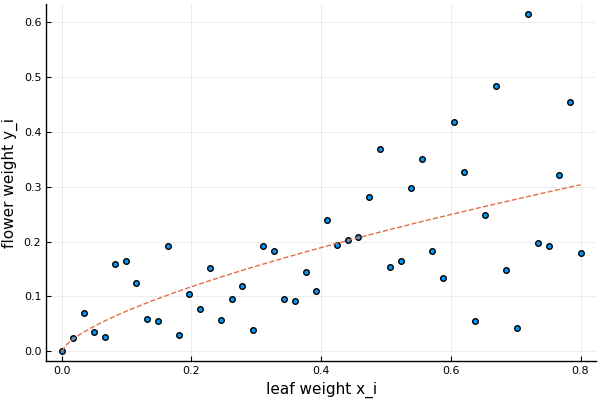

In [30]:
@df dg scatter(:x, :y, xlabel="leaf weight x_i", ylabel="flower weight y_i", legend=false)
newx = range(0.0, stop=0.8, length=100)
newy = exp.(0.683346 * log.(newx) .- 1.04019)
plot!(newx, newy, linestyle=:dash)